In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, r2_score, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Input

2024-09-04 17:52:17.721331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 17:52:17.748456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:52:17.748489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:52:17.749569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 17:52:17.753934: I tensorflow/core/platform/cpu_feature_gua

# Data Validation

Before beginning the project, the data must first be validated. We ensure that the description provided in report is accurate and that there are no discrepancies in the dataset.
Below is a description of how each column will be handled:

- Recipe: Ensure the lack of duplicates
- Calories: Ensure that the number of calories is consistent with carbohydrate and protein values. Negative values are not allowed. Null values are replaced by the median.
- Carbohydrates: Negative values are not allowed. Null values are replaced by the median.
- Sugar: Negative values are not allowed. Null values are replaced by the median
- Protein: Negative values are not allowed. Null values are replaced by the median
- Category: Value must be one of the following: (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'). 
- Servings: Negative values are not allowed. Floating points are allowed. "4 as a snack" and "6 as a snack" are converted to 3 and 5 respectively.
- High Traffic: Firstly, we verify that the only present values are "High" and NaN. We then convert these values to 1s and 0s respectively.

In [2]:
df =  pd.read_csv("../Data/recipe_site_traffic_2212.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


In [3]:
print(df.describe()) # All values are about what we expect. We notice that none of the minima are negative.

           recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375000    1.690000    3.195000
50%    474.000000   288.550000     21.480000    4.550000   10.800000
75%    710.500000   597.650000     44.965000    9.800000   30.200000
max    947.000000  3633.160000    530.420000  148.750000  363.360000


In [4]:
df[df["calories"].isna()].head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,NaN
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High


In [5]:
medians = {
    "calories": df["calories"].median(),
    "carbohydrate": df["carbohydrate"].median(),
    "sugar": df["sugar"].median(),
    "protein": df["protein"].median()
}
df.fillna(value=medians, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


Output suggests that NaNs do not represent 0 calories. These values will be imputed with the median. I chose this approach for two reasons:
1. As will become apparent later, the macronutrient values do not have a large effect on the target variable. 
2. As is shown in later visualizations, the data is highly skewed. As such, the median is a better measure of centrality than the mean.

In [6]:
print(df["high_traffic"].unique())
def binarize_high_traffic(x):
    if x == "High":
        return 1
    else:
        return 0
df["high_traffic"] = df["high_traffic"].apply(binarize_high_traffic).astype(bool)

['High' nan]


In [7]:
print(df["servings"].min())
print(df["servings"].unique())
print(df[df["servings"].str.endswith("as a snack")])

1
['6' '4' '1' '2' '4 as a snack' '6 as a snack']
     recipe  calories  carbohydrate  sugar  protein      category  \
451     452   1542.53         14.73   5.71    29.92  Lunch/Snacks   
548     549   1440.69         30.59   5.78    30.63  Lunch/Snacks   
735     736    513.75         65.87  18.63    18.39  Lunch/Snacks   

         servings  high_traffic  
451  4 as a snack          True  
548  6 as a snack          True  
735  4 as a snack         False  


"4 as a snack" and "6 as a snack" are odd. Since the servings column's intent is to capture quantity and whether or not something is a snack is reflected in the category field, these values will be treated by converting them into 4 and 6 respectively. Fortunately, these values are not commonplace, so this decision won't have big sway on the results. 

In [8]:
def convert_servings(x):
    if x == "4 as a snack":
        return "4"
    elif x == "6 as a snack":
        return "6"
    else:
        return x

df["servings"] = df["servings"].apply(convert_servings).astype(int)
print(df["servings"].unique())

[6 4 1 2]


In [9]:
print(df[df["recipe"].duplicated()]) # No duplicates. Duplicate observations are allowed since they represent different way of cooking the same ingredients
df = df.set_index("recipe")

Empty DataFrame
Columns: [recipe, calories, carbohydrate, sugar, protein, category, servings, high_traffic]
Index: []


In [10]:
def valid_cal(x, y, t):
    if 4*x + 4*y > t:
        return False
    else:
        return True

valids = df.apply(lambda row: valid_cal(row['carbohydrate'], row['protein'], row['calories']), axis=1)
print("Number of discrepant data points: ", df.shape[0] - valids.sum())

Number of discrepant data points:  324


In [11]:
print(df.iloc[0,:])

calories        288.55
carbohydrate     21.48
sugar             4.55
protein           10.8
category          Pork
servings             6
high_traffic      True
Name: 1, dtype: object


In [12]:
print("Number of data points where sugar exceeds carbohydrates: ", df[df["carbohydrate"] < df["sugar"]].shape[0])

Number of data points where sugar exceeds carbohydrates:  185


This result indicates that 324 observations have higher carbohydrate and protein counts than the calorie count of the recipe would allow. 
To explain this further, every gram of carbohydrates contains about 4 calories, and every gram of protein also contains about 4 calories. Thus, it would not make sense for a recipe to have 35.48 calories total while also having 38.56 grams of carbohydrates, as is the case with recipe #2 in the dataset.
 
I debated whether to change this data to better reflect the reality of these recipes, but I decided against it because of the goal of the project. Since we are attempting to predict high traffic based on stated nutritional facts about the recipes, it is in the best interest of the study to keep the data as is in order to understand how customers are swayed by such data. 
The same rationale applies to data points where the grams of sugar exceed the grams of carbohydrates. Since sugars are a subset of carbohydrates, such data points should be invalid.
It is alarming that 324 of the recipes in the dataset have incorrect nutritional facts, and the company is advised to proide more accurate nutritional facts in the future. This not only helps consumers make more informed choices, but it also aids in post-mortem data analysis projects such as this one since such analyses won't have to take into account the nutrition-savvy consumers who are capable of noticing such discrepancies. 

In [13]:
print(df["category"].unique()) # Chicken Breast is not allowed
df["category"] = df["category"].str.replace("Chicken Breast", "Chicken").astype("category")
print(df["category"].unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


In [14]:
df["category"] = df["category"].astype("category")

In [15]:
print(df.groupby("servings")[["calories", "carbohydrate", "sugar", "protein"]].agg(["mean", "std"])) # Making sure nutritional counts represent the per person values.

            calories             carbohydrate                sugar             \
                mean         std         mean        std      mean        std   
servings                                                                        
1         482.557143  494.354825    34.498686  43.256287  8.739943  16.273566   
2         409.929126  388.014526    35.162350  39.899353  9.151639  15.131772   
4         417.885703  440.921487    35.201586  45.317010  8.886777  13.945155   
6         415.718889  440.039439    31.659192  40.163768  8.355000  12.334305   

            protein             
               mean        std  
servings                        
1         24.767714  30.117242  
2         25.198251  41.587963  
4         21.823299  28.900587  
6         23.720606  44.553102  


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      947 non-null    float64 
 1   carbohydrate  947 non-null    float64 
 2   sugar         947 non-null    float64 
 3   protein       947 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    int64   
 6   high_traffic  947 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(1)
memory usage: 46.6 KB
None


### Summary of Data Validation and Cleaning

I verified that the dataset has 947 rows and 8 columns.
- recipe: ensured that there are no duplicates
- calories: ensured the lack of negative values; replaced NaN values with median; checked that it was internally consistent with protein and carbohydrate columns and found many discrepancies but chose to keep them, Range: [0.14, 3633.16]
- carbohydrate: ensured the lack of negative values; replaced NaN values with median, Range: [0.03, 530.42]
- sugar: ensured the lack of negative values; replaced NaN values with median; checked that grams of sugar did not exceed gram of carbohydrates, found discrepancies, but chose to keep the data as is, Range: [0.01, 148.75]
- protein: ensured the lack of negative values; replaced NaN values with median, Range: [0, 363.36]
- category: converted column to categorical; looked at the unique values and found "Chicken Breast" which is not allowed, thus converted it to "Chicken"
- servings: converted "4 as a snack" and "6 as a snack" to 4 and 6 respectively; converted column to numeric, Range: [1, 6]
- high_traffic: replaced "High" and NaN with True and False respectively, thus converting the column to boolean

# Exploratory Data Analysis

After spending some time cleaning the data, I've started to get some sense of the data and the relationship between the different features. The goal of the next section is to delve deeper into these relationships. This should ultimately shed light on how the data should be processed or transformed for model creation later on.

In [17]:
sns.set()
sns.set_palette("coolwarm")

#### Description Table showing the Numerical Variable Ranges

In [18]:
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,427.846019,34.323464,8.799641,23.416283,3.477297
std,441.673556,42.836191,14.306785,35.486699,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


#### High Traffic Recipe Proportion

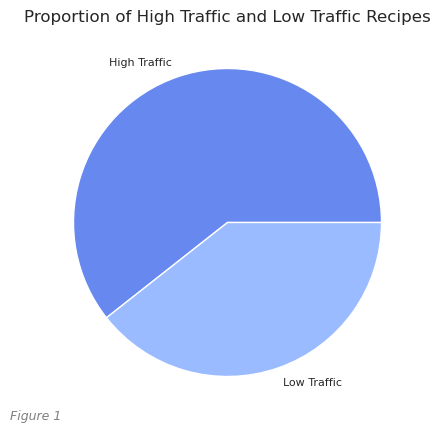

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.pie(df["high_traffic"].value_counts(), labels=["High Traffic", "Low Traffic"], textprops={'fontsize': 8})
plt.title("Proportion of High Traffic and Low Traffic Recipes")
fig.text(0.15, 0.1, "Figure 1", ha="left", fontsize=9, color="grey", fontstyle="italic")
plt.show()

#### Heatmap showing Correlation between Macronutrient Variables

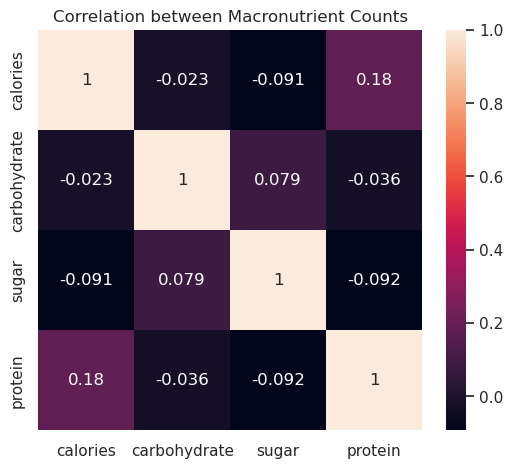

In [20]:
macronutrients = df[["calories", "carbohydrate", "sugar", "protein"]]
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(macronutrients.corr(), annot=True).set(title="Correlation between Macronutrient Counts") # Variables are not correlated at all. An unusual result, especially for features such as carbohydrate and sugar.
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.savefig("../Vis/macros-correlations.png", bbox_inches='tight', dpi=300)

#### Calories Distribution

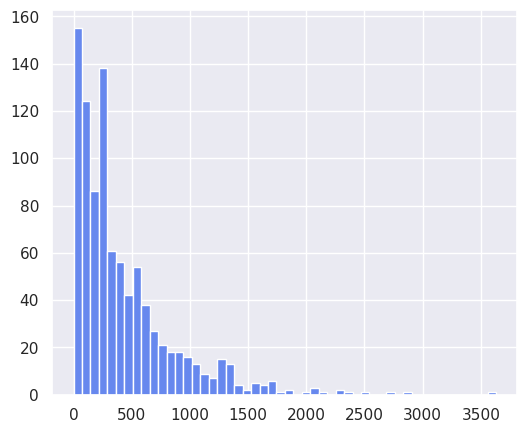

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = plt.hist(df["calories"], bins=50)
plt.savefig("../Vis/calories-distribution.png", bbox_inches='tight', dpi=300)

#### Distribution of Calories, Carbohydrate, and Protein grouped by different Food Categories

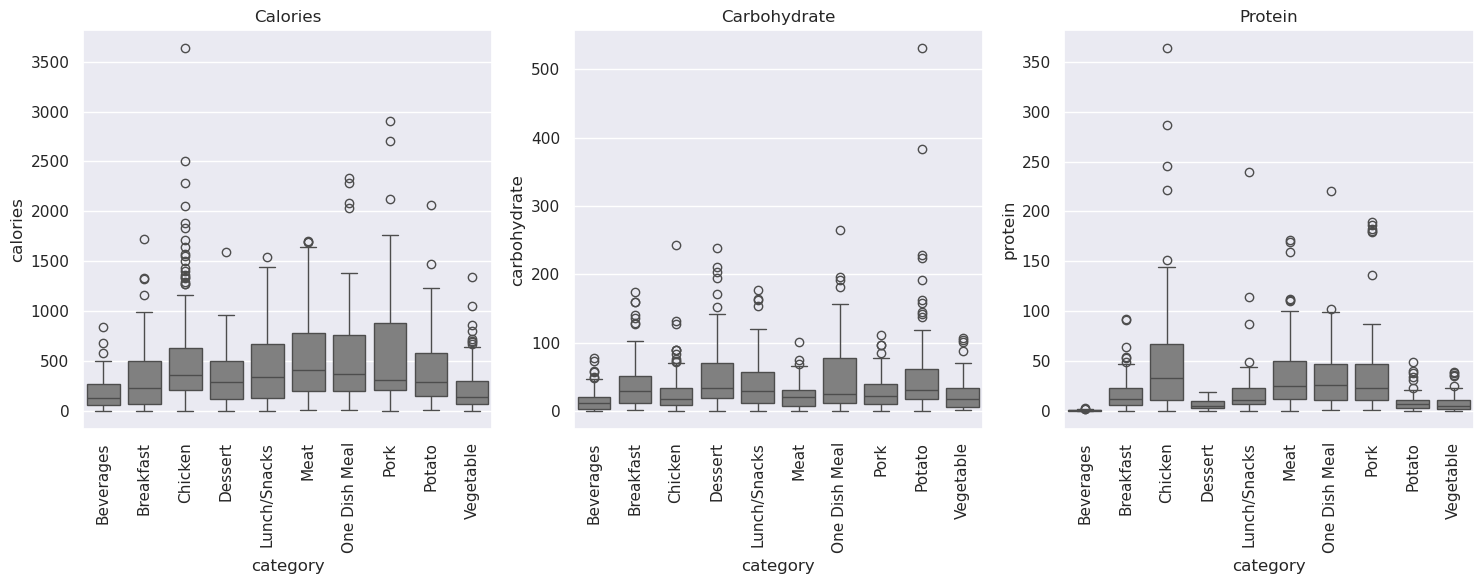

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.set_palette("cool")

sns.boxplot(ax=axes[0], data=df, x="category", y="calories", color="gray")
axes[0].set_title("Calories")
axes[0].tick_params(axis="x", rotation=90)

sns.boxplot(ax=axes[1], data=df, x="category", y="carbohydrate", color="gray")
axes[1].set_title("Carbohydrate")
axes[1].tick_params(axis="x", rotation=90)

sns.boxplot(ax=axes[2], data=df, x="category", y="protein", color="gray")
axes[2].set_title("Protein")
axes[2].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig("../Vis/macro-boxplots.png", bbox_inches='tight', dpi=300)

In [23]:
df["calories_log"] = np.log1p(df["calories"])
df["carbohydrate_log"] = np.log1p(df["carbohydrate"])
df["sugar_log"] = np.log1p(df["sugar"])
df["protein_log"] = np.log1p(df["protein"])

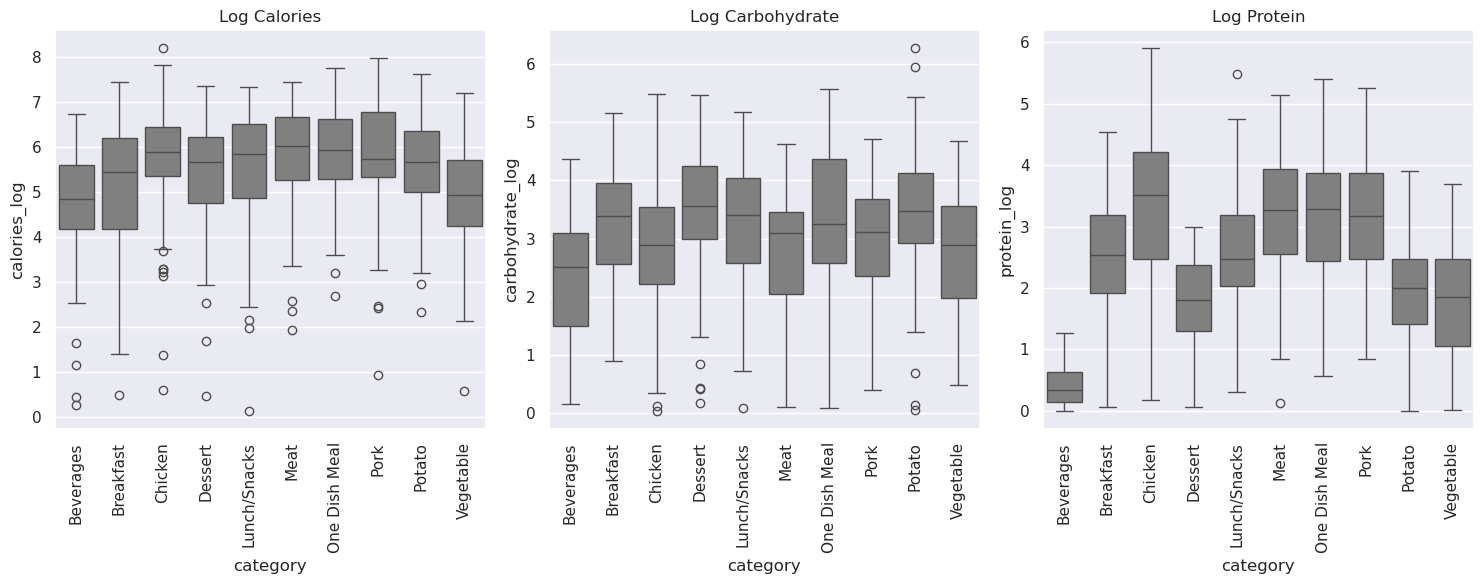

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(ax=axes[0], data=df, x="category", y="calories_log",color="gray")
axes[0].set_title("Log Calories")
axes[0].tick_params(axis="x", rotation=90)

sns.boxplot(ax=axes[1], data=df, x="category", y="carbohydrate_log",color="gray")
axes[1].set_title("Log Carbohydrate")
axes[1].tick_params(axis="x", rotation=90)

sns.boxplot(ax=axes[2], data=df, x="category", y="protein_log",color="gray")
axes[2].set_title("Log Protein")
axes[2].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig("../Vis/less-skewed-macro-boxplots", bbox_inches='tight', dpi=300)

In [25]:
print("Calories Skew: ", df["calories"].skew())
print("Log Calories Skew: ", df["calories_log"].skew())
print()
print("Carbohydrate Skew: ", df["carbohydrate"].skew())
print("Log Carbohydrate Skew: ", df["carbohydrate_log"].skew())
print()
print("Sugar Skew: ", df["sugar"].skew())
print("Log Sugar Skew: ", df["sugar_log"].skew())
print()
print("Protein Skew: ", df["protein"].skew())
print("Log Protein Skew", df["protein_log"].skew())

Calories Skew:  2.129173366195534
Log Calories Skew:  -0.9981030543220842

Carbohydrate Skew:  3.8845747199580285
Log Carbohydrate Skew:  -0.3064329261589476

Sugar Skew:  4.360693295798306
Log Sugar Skew:  0.5180397469005632

Protein Skew:  3.6290761376350478
Log Protein Skew -0.0200962251561247


### Distribution of High Traffic Recipes among Food Categories

/tmp/ipykernel_453/703947572.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  traffic_counts = df.groupby(["category", "high_traffic"]).size().unstack(fill_value=0)


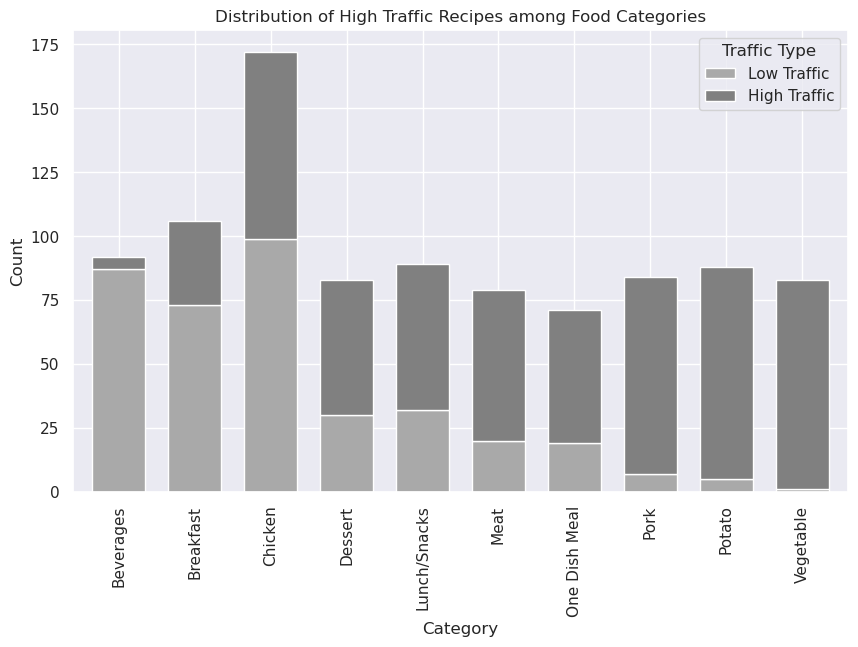

In [26]:
traffic_counts = df.groupby(["category", "high_traffic"]).size().unstack(fill_value=0)
# Plot stacked bar chart
sns.set_palette("gist_stern")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the lower segment (low traffic)
traffic_counts[False].plot(kind="bar", ax=ax, color="darkgray", label="Low Traffic", width=0.7)

# Plot the upper segment (high traffic) on top of the lower segment
traffic_counts[True].plot(kind="bar", ax=ax, color = "gray", label="High Traffic", bottom=traffic_counts[False], width=0.7)

ax.set_title("Distribution of High Traffic Recipes among Food Categories")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)
ax.legend(title="Traffic Type")

plt.savefig("../Vis/traffic-per-category.png", bbox_inches='tight', dpi=300)

### Relationship between Predictors and High Traffic

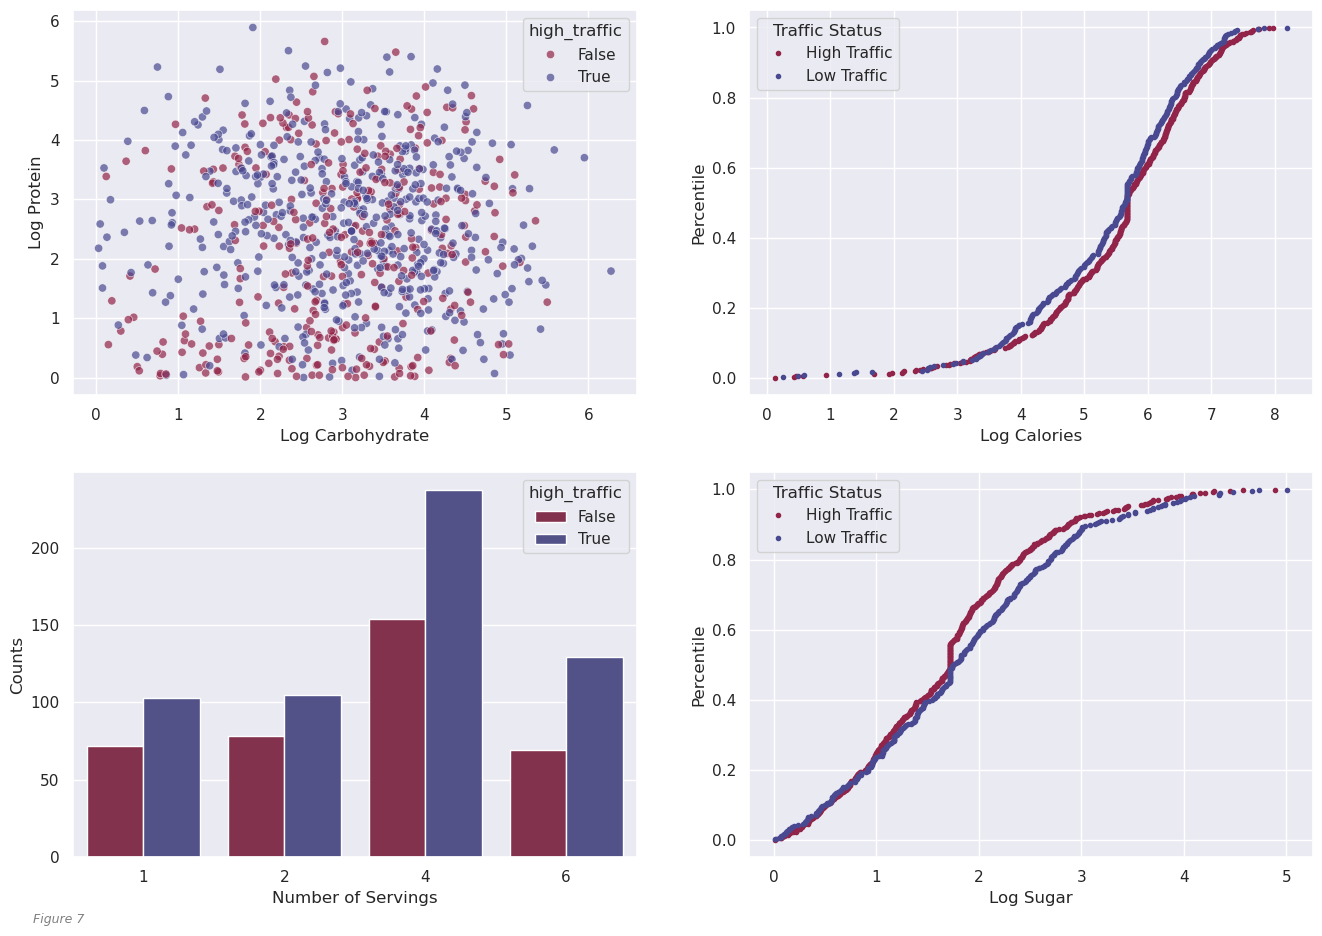

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

traffic_servings_counts = df.groupby(["servings", "high_traffic"]).size().reset_index(name='count')

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

sns.set_palette("gist_stern")
sns.scatterplot(ax=axes[0, 0], x="carbohydrate_log", y="protein_log", hue="high_traffic", alpha=0.7, data=df)
axes[0, 0].set_xlabel("Log Carbohydrate")
axes[0, 0].set_ylabel("Log Protein")

sns.barplot(ax=axes[1, 0], x="servings", y="count", hue="high_traffic", data=traffic_servings_counts, err_kws={'linewidth': 1.5, "color": "gray"}, capsize=0.3)
axes[1, 0].set_xlabel("Number of Servings")
axes[1, 0].set_ylabel("Counts")

high_t = df[df["high_traffic"] == True]
low_t = df[df["high_traffic"] == False]

cal_x_h, cal_y_h = ecdf(high_t["calories_log"])
cal_x_l, cal_y_l = ecdf(low_t["calories_log"])

axes[0, 1].plot(cal_x_h, cal_y_h, marker=".", linestyle="none", label="High Traffic")
axes[0, 1].plot(cal_x_l, cal_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[0, 1].set_xlabel("Log Calories")
axes[0, 1].set_ylabel("Percentile")
axes[0, 1].legend(title="Traffic Status")

sug_x_h, sug_y_h = ecdf(high_t["sugar_log"])
sug_x_l, sug_y_l = ecdf(low_t["sugar_log"])

axes[1, 1].plot(sug_x_h, sug_y_h, marker=".", linestyle="none", label="High Traffic")
axes[1, 1].plot(sug_x_l, sug_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[1, 1].set_xlabel("Log Sugar")
axes[1, 1].set_ylabel("Percentile")
axes[1, 1].legend(title="Traffic Status")
fig.text(0.1, 0.05, "Figure 7", ha="left", fontsize=9, color="grey", fontstyle="italic")

plt.show()

In [28]:
grouped_df = df.groupby(["servings", "category"])["high_traffic"].mean()*100

/tmp/ipykernel_453/1402622795.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(["servings", "category"])["high_traffic"].mean()*100


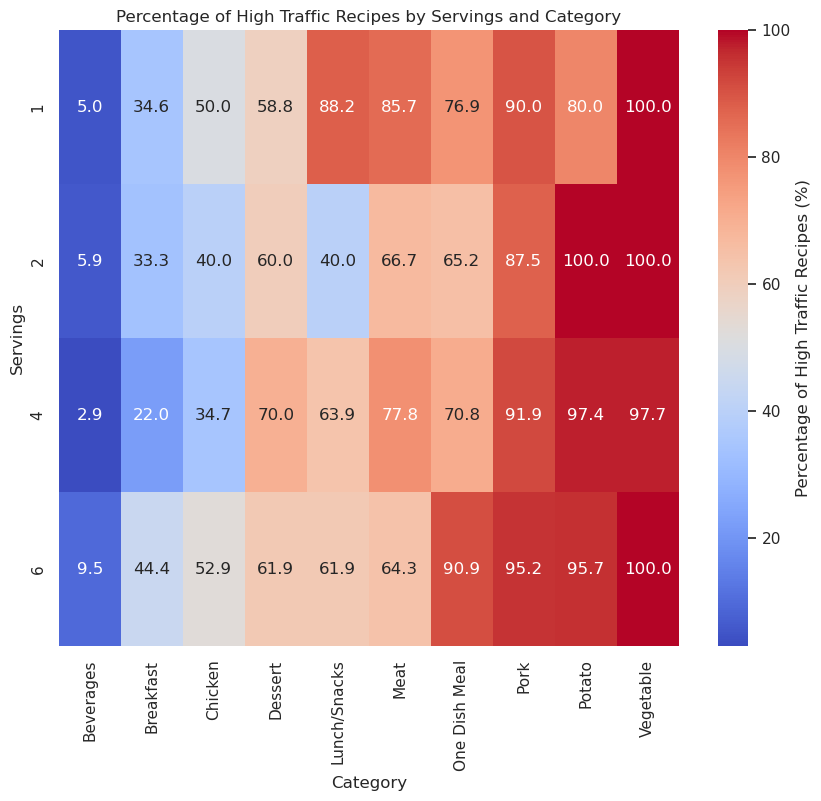

In [29]:
heatmap_data = grouped_df.unstack()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "Percentage of High Traffic Recipes (%)"})
plt.title("Percentage of High Traffic Recipes by Servings and Category")
plt.ylabel("Servings")
plt.xlabel("Category")
plt.savefig("../Vis/category-serving-heatmap.png", bbox_inches='tight', dpi=300)

### EDA Summary

I started by plotting the target variable on a pie chart to see whether the dataset was biased to one class. As you can see from Figure 1, there is an imbalance, but it should not be problematic.

Next, I tried plotting a heatmap of all the macronutrient variables in the dataset. To my surprise there is little to no correlation between these values. I would have expected some variables such as carbohydrate and sugar levels to be correlated given that sugar is a subset of carbohydrate. 

In the next stage, I decided to plot a histogram to visualize the distribution of the calories variable. It appeared to be very highly skewed. I had a feeling this property would be variable based on the food category. Therefore, I decided to draw a series of boxplots showing the distribution of calories as well as carbohydrate and protein levels across different categories. All of the data appeared to be skewed to the right. As such, I chose to apply a log transformation to reduce the skew of the data. I created Figure 5 to ensure that the transformation had the desired effect, and I calculated the skew of the relevant variables before and after the log transformation.

Furthermore, Figure 6 showcases the distribution of high traffic recipes among food categories. As you can see, some categories outperform others vastly, even after taking the class imbalance. Foods from theb vegetable, potato, and pork categories are commonly high traffic whereas recipes for the chicken, breakfast, and beverage categories almost never give high traffic to the website. 

Figure 7 depicts the relationship between the target variable and all other predictors. Macronutrients don't seem to have a significant sway on traffic. The ECDFs displayed on the right side of Figure 7 suggest that there is some difference in the calorie and sugar levels, but it is not particularly distinctive. On the bottom left we see that serving size and high traffic are somewhat correlated, with recipes having high serving sizes showing greater proportions of high traffic.

I find Figure 8 to be highly informative. It shows which categories accrue the most traffic for the website based on the number of servings. The interesting results lie cases that do not conform to the rest of the serving sizes. For instance, Lunch/Snacks performs very highly for a serving size of 1 (Percent high traffic = 88.2%), but does not do as well for other serving sizes. One dish meals score highly for serving sizes of 6 but not on other serving sizes. 

Findings:
- Calories, Carbohydrate, Sugar, and Protein values for low and high traffic recipes are very similar on average (see figure 7), meaning that they likely won't contribute to the classification process.
- The heatmap shows a good association between the predictors category and servings with the target variable.
- The plots show that macronutrient data is highly skewed, justifying a log transformation.

# Preprocessing for Machine Learning

In the following section, the data is preprocessed to be made amenable for machine learning. Below is a summary of the procedures:
- Log-Transformation: This was already done earlier. The transformation was applied to reduce the skew of the data.
- Scaling: The macronutrient data is shifted to have a mean of 0 and then scaled to have a variance of 1. It is suspected that this change will lead to an increase in model performance, ultimately.
- Feature Engineering: Macrinutrient ratios are defined. 
- Creating Dummy Variables: The category column should be converted to one-hot format so that it may be fed into machine learning models.
- Predictor and Target Separation: Predictor variables are assigned to a variable X whereas the target variable "high_traffic" is assigned to a variable y
- Train-test Split: The dataset is fractioned into a training and validation set.

In [30]:
print(df.head())

        calories  carbohydrate  sugar  protein   category  servings  \
recipe                                                                
1         288.55         21.48   4.55    10.80       Pork         6   
2          35.48         38.56   0.66     0.92     Potato         4   
3         914.28         42.68   3.09     2.88  Breakfast         1   
4          97.03         30.56  38.63     0.02  Beverages         4   
5          27.05          1.85   0.80     0.53  Beverages         4   

        high_traffic  calories_log  carbohydrate_log  sugar_log  protein_log  
recipe                                                                        
1               True      5.668328          3.112626   1.713798     2.468100  
2               True      3.596764          3.677819   0.506818     0.652325  
3              False      6.819230          3.776890   1.408545     1.355835  
4               True      4.585274          3.451890   3.679586     0.019803  
5              False      3.

In [31]:
df_cat = pd.get_dummies(df["category"], prefix="category")
df = pd.concat([df, df_cat], axis=1)

In [32]:
print(df_cat.columns)

Index(['category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable'],
      dtype='object')


In [33]:
categories = df_cat.columns

interaction_terms = []

for category in categories:
    interaction_term_name = f"{category}_servings"
    interaction_terms.append(interaction_term_name)
    df[interaction_term_name] = df[category] * df["servings"]

In [34]:
scaler = StandardScaler()
numeric_features = ["calories_log", "carbohydrate_log", "sugar_log", "protein_log", "servings"] + interaction_terms
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [35]:
print(df.describe())

          calories  carbohydrate       sugar     protein      servings  \
count   947.000000    947.000000  947.000000  947.000000  9.470000e+02   
mean    427.846019     34.323464    8.799641   23.416283 -2.626082e-17   
std     441.673556     42.836191   14.306785   35.486699  1.000528e+00   
min       0.140000      0.030000    0.010000    0.000000 -1.430454e+00   
25%     114.410000      9.135000    1.795000    3.465000 -8.530285e-01   
50%     288.550000     21.480000    4.550000   10.800000  3.018221e-01   
75%     576.225000     42.590000    9.285000   28.530000  3.018221e-01   
max    3633.160000    530.420000  148.750000  363.360000  1.456673e+00   

       calories_log  carbohydrate_log     sugar_log   protein_log  \
count  9.470000e+02      9.470000e+02  9.470000e+02  9.470000e+02   
mean   1.200495e-16      2.926206e-16  7.503091e-17  1.650680e-16   
std    1.000528e+00      1.000528e+00  1.000528e+00  1.000528e+00   
min   -4.206271e+00     -2.677035e+00 -1.811096e+00 -1.89

In [36]:
df["carb_to_cal"] = np.log1p(df["carbohydrate"] * 4 / df["calories"])
df["protein_to_cal"] = np.log1p(df["protein"] * 4 / df["calories"])
df["sugar_to_carb"] = np.log1p(df["sugar"] / df["carbohydrate"])
df["protein_to_carb"] = np.log1p(df["protein"] / df["carbohydrate"])

In [37]:
print(df.groupby("high_traffic")[["carb_to_cal", "protein_to_cal", "sugar_to_carb", "protein_to_carb"]].agg(np.mean))

              carb_to_cal  protein_to_cal  sugar_to_carb  protein_to_carb
high_traffic                                                             
False            0.533673        0.333483       0.499600         0.674250
True             0.543559        0.367848       0.417627         0.802036


/tmp/ipykernel_453/1545835891.py:1: FutureWarning: The provided callable <function mean at 0x7f8931529620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  print(df.groupby("high_traffic")[["carb_to_cal", "protein_to_cal", "sugar_to_carb", "protein_to_carb"]].agg(np.mean))


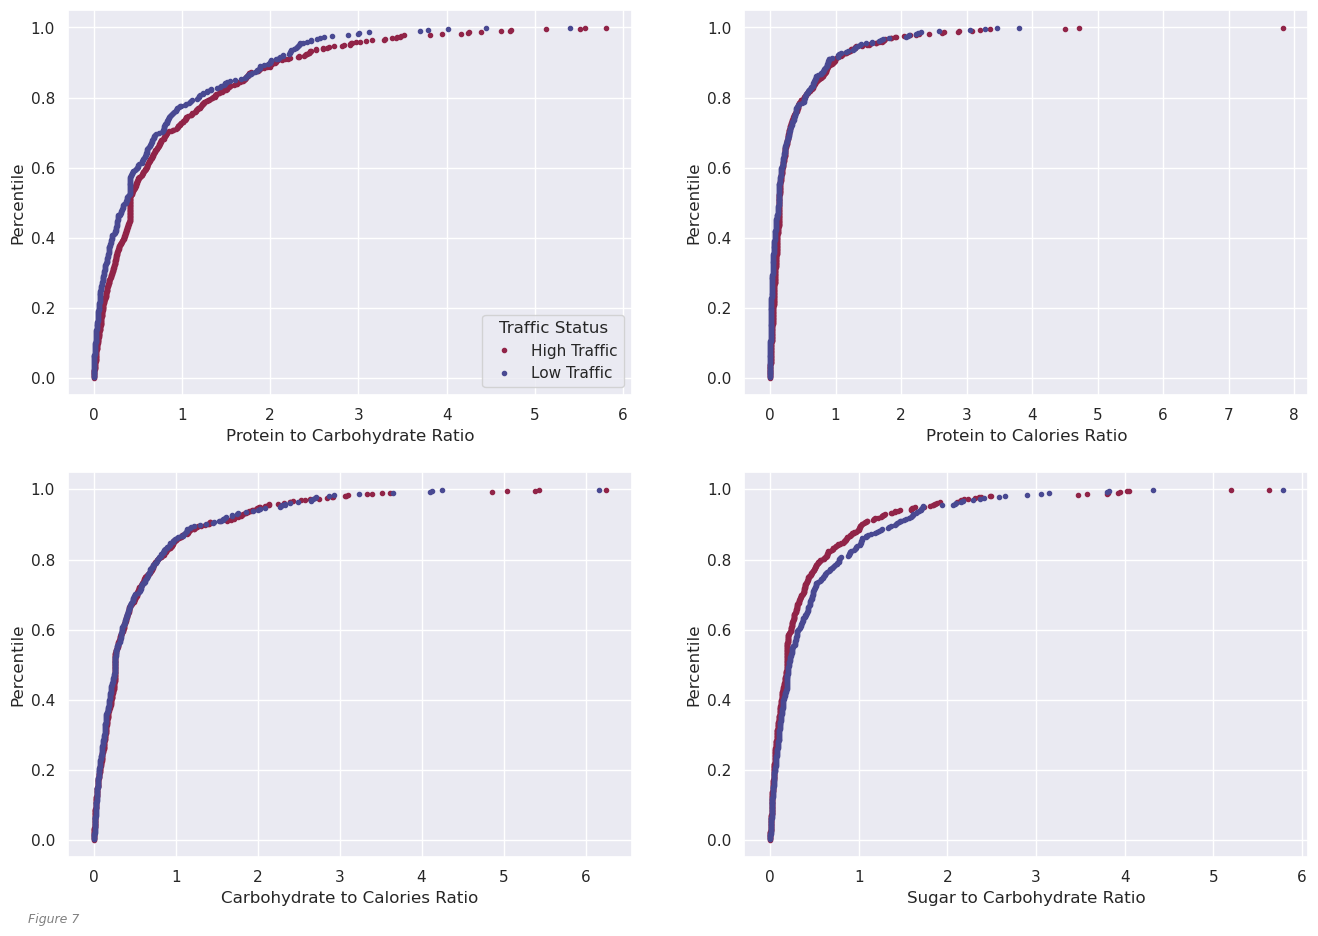

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

sns.set_palette("gist_stern")

high_t = df[df["high_traffic"] == True]
low_t = df[df["high_traffic"] == False]

prot_x_h, prot_y_h = ecdf(high_t["protein_to_carb"])
prot_x_l, prot_y_l = ecdf(low_t["protein_to_carb"])

axes[0, 0].plot(prot_x_h, prot_y_h, marker=".", linestyle="none", label="High Traffic")
axes[0, 0].plot(prot_x_l, prot_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[0, 0].set_xlabel("Protein to Carbohydrate Ratio")
axes[0, 0].set_ylabel("Percentile")
axes[0, 0].legend(title="Traffic Status")

pro_x_h, pro_y_h = ecdf(high_t["carb_to_cal"])
pro_x_l, pro_y_l = ecdf(low_t["carb_to_cal"])

axes[1, 0].plot(pro_x_h, pro_y_h, marker=".", linestyle="none", label="High Traffic")
axes[1, 0].plot(pro_x_l, pro_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[1, 0].set_xlabel("Carbohydrate to Calories Ratio")
axes[1, 0].set_ylabel("Percentile")

cal_x_h, cal_y_h = ecdf(high_t["protein_to_cal"])
cal_x_l, cal_y_l = ecdf(low_t["protein_to_cal"])

axes[0, 1].plot(cal_x_h, cal_y_h, marker=".", linestyle="none", label="High Traffic")
axes[0, 1].plot(cal_x_l, cal_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[0, 1].set_xlabel("Protein to Calories Ratio")
axes[0, 1].set_ylabel("Percentile")

sug_x_h, sug_y_h = ecdf(high_t["sugar_to_carb"])
sug_x_l, sug_y_l = ecdf(low_t["sugar_to_carb"])

axes[1, 1].plot(sug_x_h, sug_y_h, marker=".", linestyle="none", label="High Traffic")
axes[1, 1].plot(sug_x_l, sug_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[1, 1].set_xlabel("Sugar to Carbohydrate Ratio")
axes[1, 1].set_ylabel("Percentile")
fig.text(0.1, 0.05, "Figure 7", ha="left", fontsize=9, color="grey", fontstyle="italic")

plt.show()

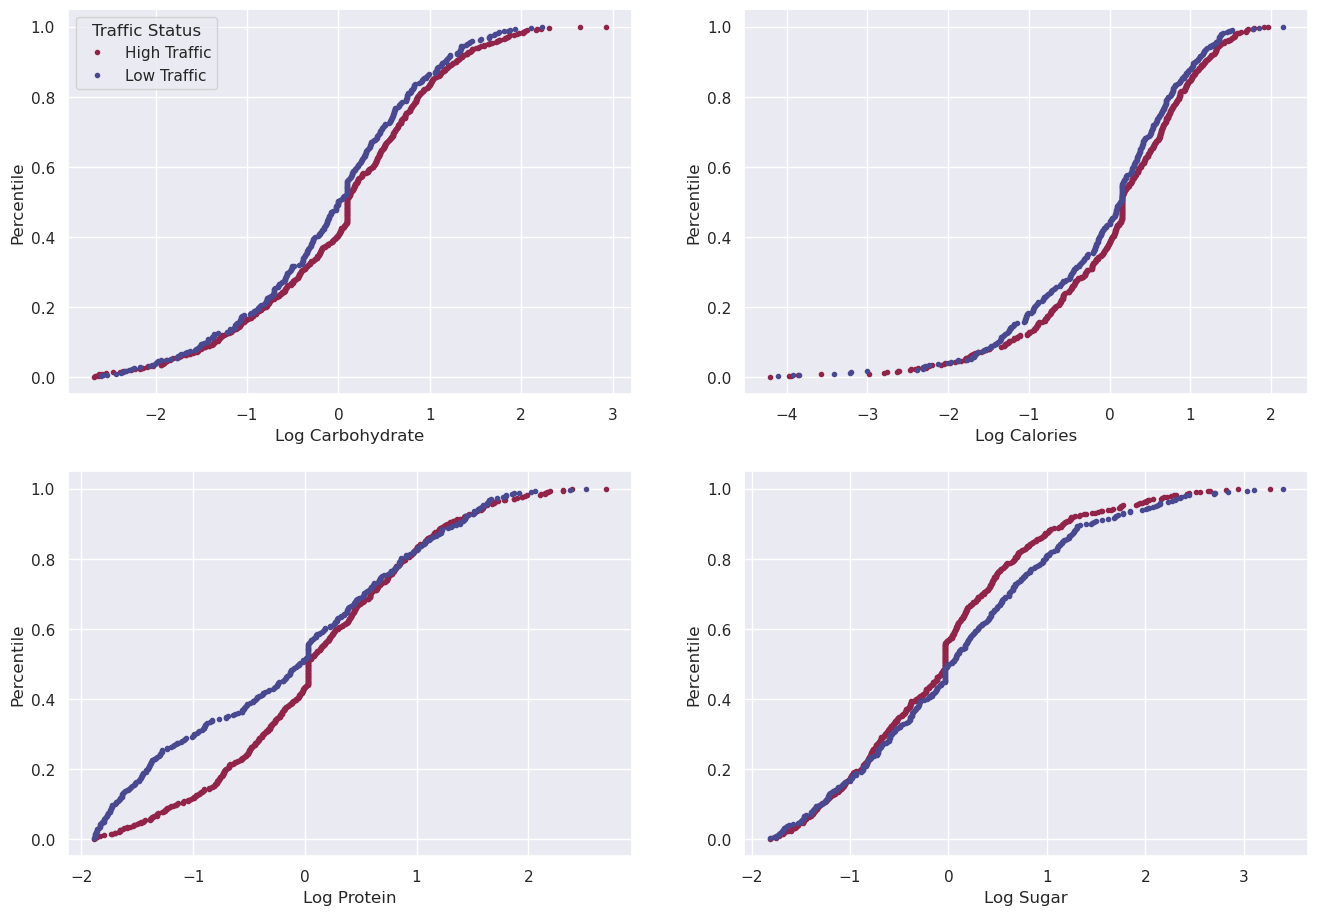

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

sns.set_palette("gist_stern")

high_t = df[df["high_traffic"] == True]
low_t = df[df["high_traffic"] == False]

prot_x_h, prot_y_h = ecdf(high_t["carbohydrate_log"])
prot_x_l, prot_y_l = ecdf(low_t["carbohydrate_log"])

axes[0, 0].plot(prot_x_h, prot_y_h, marker=".", linestyle="none", label="High Traffic")
axes[0, 0].plot(prot_x_l, prot_y_l, marker=".", linestyle="none", label="Low Traffic")
axes[0, 0].set_xlabel("Log Carbohydrate")
axes[0, 0].set_ylabel("Percentile")
axes[0, 0].legend(title="Traffic Status")

pro_x_h, pro_y_h = ecdf(high_t["protein_log"])
pro_x_l, pro_y_l = ecdf(low_t["protein_log"])

axes[1, 0].plot(pro_x_h, pro_y_h, marker=".", linestyle="none")
axes[1, 0].plot(pro_x_l, pro_y_l, marker=".", linestyle="none")
axes[1, 0].set_xlabel("Log Protein")
axes[1, 0].set_ylabel("Percentile")

cal_x_h, cal_y_h = ecdf(high_t["calories_log"])
cal_x_l, cal_y_l = ecdf(low_t["calories_log"])

axes[0, 1].plot(cal_x_h, cal_y_h, marker=".", linestyle="none")
axes[0, 1].plot(cal_x_l, cal_y_l, marker=".", linestyle="none")
axes[0, 1].set_xlabel("Log Calories")
axes[0, 1].set_ylabel("Percentile")

sug_x_h, sug_y_h = ecdf(high_t["sugar_log"])
sug_x_l, sug_y_l = ecdf(low_t["sugar_log"])

axes[1, 1].plot(sug_x_h, sug_y_h, marker=".", linestyle="none")
axes[1, 1].plot(sug_x_l, sug_y_l, marker=".", linestyle="none")
axes[1, 1].set_xlabel("Log Sugar")
axes[1, 1].set_ylabel("Percentile")
plt.savefig("../Vis/macro-ecdfs.png", bbox_inches='tight', dpi=300)

The plotted ECDFs aim to show that macronutrient ratios help distinguish high and low traffic recipes and do so better than the original macronutrient values. Unfortunately, this isn't very apparent, especially in the case of Log Protein which appears to separate high and low traffic very well. However, as would see in the logistic regression model if we were to use these features, that would not be the case. Examine the following figure which shows the weights of features in a Logistic Regression model. Note the value of macro weights and compare them to that of ratios. They all seem to have weights close to zero while ratios like carb_to_cal and protein_to_cal have higher absolute values.

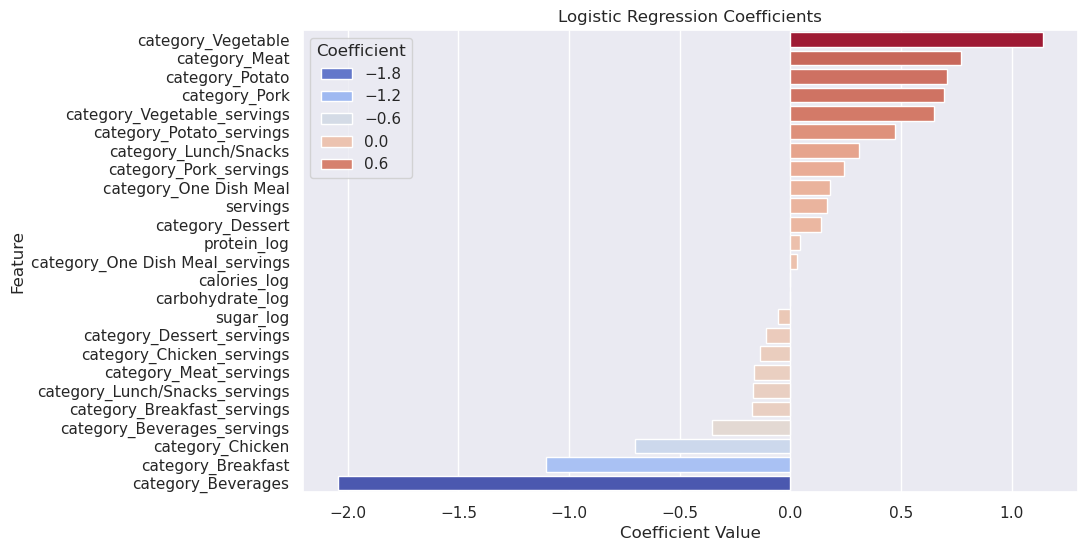

In [40]:
macros = ["calories_log", "carbohydrate_log", "sugar_log", "protein_log"]
macro_ratios = ["carb_to_cal", "protein_to_cal", "sugar_to_carb", "protein_to_carb"]
categories = ["category_Beverages", "category_Breakfast", "category_Chicken",
       "category_Dessert", "category_Lunch/Snacks", "category_Meat", "category_One Dish Meal", "category_Pork", "category_Potato", "category_Vegetable"]

X = df[["servings"] + interaction_terms + categories + macros]
y = df["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, stratify=y,random_state=42)

lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

log_coef = pd.DataFrame(lr.coef_.flatten(), columns=['Coefficient'], index=X.columns)


log_coef_sorted = log_coef.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=log_coef_sorted.index, x=log_coef_sorted['Coefficient'], orient='h', palette='coolwarm', hue = log_coef_sorted['Coefficient'])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.savefig('../Vis/alt-logistic-regression-coefficients.png', bbox_inches='tight', dpi=300)

In [41]:
macros = ["calories_log", "carbohydrate_log", "sugar_log", "protein_log"]
macros_unmod = ["calories", "carbohydrate", "sugar", "protein"]
macro_ratios = ["carb_to_cal", "protein_to_cal", "sugar_to_carb", "protein_to_carb"]
categories = ["category_Beverages", "category_Breakfast", "category_Chicken",
       "category_Dessert", "category_Lunch/Snacks", "category_Meat", "category_One Dish Meal", "category_Pork", "category_Potato", "category_Vegetable"]

X = df[["servings"] + interaction_terms + macro_ratios + categories]
y = df["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, stratify=y,random_state=42)

# Model Fitting and Evaluation

At this stage, we begin building machine learning models to properly fulfill the business requirement. The problem at hand is a **classification** problem. Our goal is to correctly classify recipes as being high or low traffic based on already known data about the recipe. As such, two models are described in this report:
1. Logistic Regression model: This model will serve as the baseline. Logistic regression is the standard for binary classification tasks.
2. XGBoost model: Boosted models are highly effective at making accurate predictions at the cost of interpretability. This model will be our comparison model. We also optimize the hyperparameters of the model in an attempt to improve performance.

### Logistic Regression

In [42]:
lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))

0.7762237762237763


In [43]:
print(cross_val_score(LogisticRegression(), X, y, cv=5))

[0.72631579 0.75263158 0.76719577 0.8042328  0.76719577]


In [44]:
print(np.mean(cross_val_score(LogisticRegression(), X, y, cv=150, scoring="precision")))

0.8259206349206348


In [45]:
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)
print(lr_roc_auc)

0.8698686371100164


Text(0, 0.5, 'Feature')

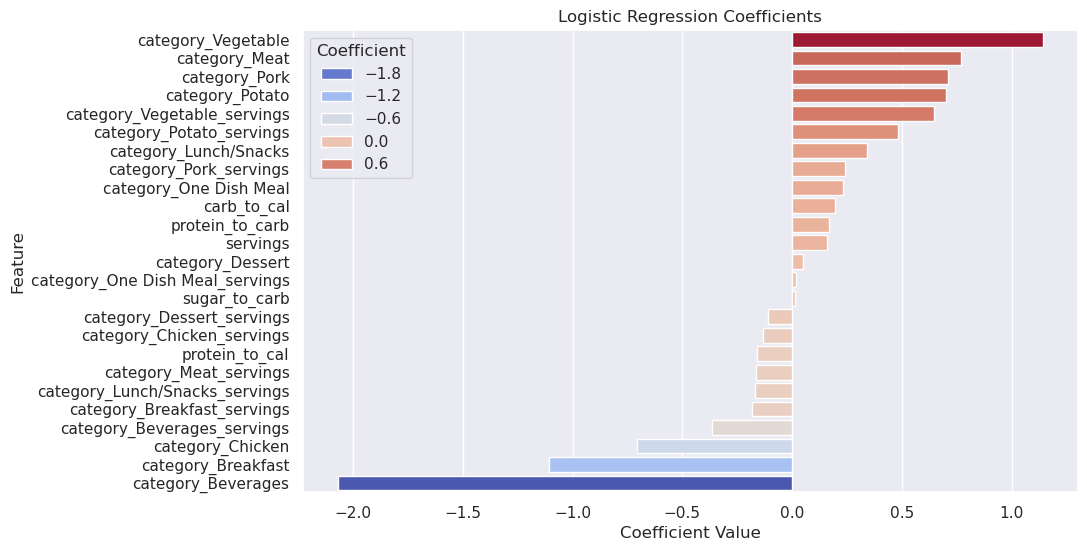

In [46]:
log_coef = pd.DataFrame(lr.coef_.flatten(), columns=['Coefficient'], index=X.columns)


log_coef_sorted = log_coef.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=log_coef_sorted.index, x=log_coef_sorted['Coefficient'], orient='h', palette='coolwarm', hue = log_coef_sorted['Coefficient'])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

### XGBoost Model

In [47]:
xgboost_model = XGBClassifier()
param_grid = {
    "n_estimators": [20, 50, 75, 100],
   "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.001, 0.0015, 0.01, 0.1],
}

# define the grid search model
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ..learning_rate=0.001, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ..learning_rate=0.0

In [48]:
y_pred_xg = grid_search.predict(X_test)
y_pred_proba_xg = grid_search.predict_proba(X_test)[:, 1]

In [49]:
print(np.mean(cross_val_score(XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=50), X, y, cv=150, scoring="precision")))

0.7943174603174602


In [52]:
print("Logistic Regression: ")
print(classification_report(y_test, y_pred_lr))

Logistic Regression: 
              precision    recall  f1-score   support

       False       0.69      0.77      0.73        56
        True       0.84      0.78      0.81        87

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



In [53]:
print("XGBoost Model: ")
print(classification_report(y_test, y_pred_xg))

XGBoost Model: 
              precision    recall  f1-score   support

       False       0.70      0.75      0.72        56
        True       0.83      0.79      0.81        87

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



In [54]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba_lr)
auc1 = roc_auc_score(y_test, y_pred_proba_lr)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_xg)
auc2 = roc_auc_score(y_test, y_pred_proba_xg)

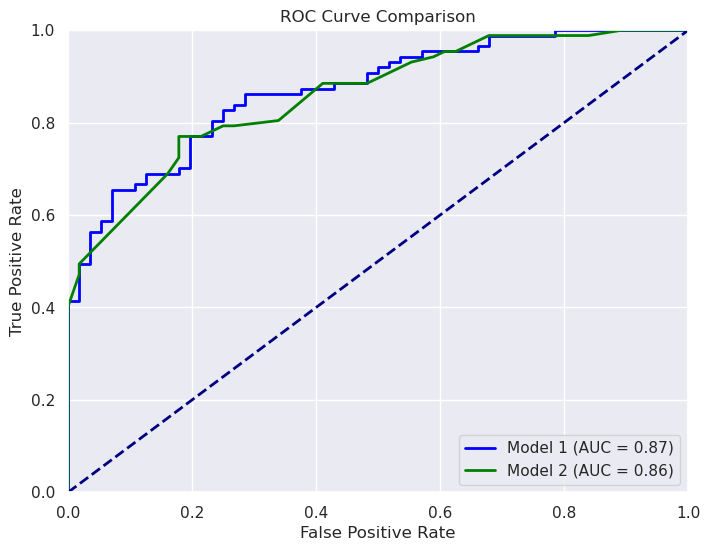

In [55]:
# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'Model 1 (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Model 2 (AUC = {auc2:.2f})')

# Plotting the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adding labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')

# Adding the legend
plt.legend(loc='lower right')
plt.savefig("../Vis/roc.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

### Model Building and Evaluation Summary

The models were built using the following predictors:
- Category
- Servings
- Category/Servings Interaction Terms
- Macronutrient ratios:
  - Protein/Cal
  - Protein/Carb
  - Carb/Cal
  - Sugar/Carb

#### Logistic Regression Model

|                | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| **False**      | 0.69      | 0.80   | 0.74     | 56      |
| **True**       | 0.86      | 0.77   | 0.81     | 87      |
| **Overall**    | 0.79      | 0.78   | 0.79     | 143     |

- Accuracy: 0.78
- AUC-score: 0.87

- True Precision: 0.86

#### XGBoost Model with hyperparameter optimization

|                | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| **False**      | 0.70      | 0.75   | 0.72     | 56      |
| **True**       | 0.83      | 0.79   | 0.81     | 87      |
| **Overall**    | 0.78      | 0.78   | 0.78     | 143     |

- Accuracy: 0.78
- AUC-score: 0.86

- True Precision: 0.83

### Interpretation

- The logistic regression model appears to perform better than the XGBoost model in many metrics including true precision, a key metric for reasons which will be discussed shortly.
- The ROC curve plot shows that the logistic regression model has a slight advantage over the XGBoost mode.
- The barplot shows the feature weights of the logistic regression model. The plot is consistent with the findings presented in the EDA section.

# Business Goal, KPI Definition, and Recommendations

### Goal

The goal of Tasty Bytes is to consistently feature high traffic recipes on the home page of their website. This should lead to more activity on the website and to increased sales ultimately. As such, the choice of recipe is key.

### Key Performance Indicator Definition and Justification

I believe a good performance indicator for this case is **True Precision**. The reason is that when the client is feeding the recipe into a model, the recipe is likely to be discarded if the model predicts that recipe will yield low traffic. As such, negative results are irrelevant to the business problem. The true question is: given a positive result from the model, how likely is this recipe to be truly high traffic. When the problem is rephrased as such, it becomes abundantly clear that precision is a better indicator for performance than accuracy.

### Model Comparison and Recommendation

With this in mind, I would recommend the use of the simple logistic regression model which has a true precision of 86. However, the caveat here is that this number is subject to variance in the train-test split. Thus, we calculate the same metric using k-fold cross-validation. With K=150, the average precision of the models is 83 as shown above.

What this means in practice is the following: If a recipe is fed into the logistic regression model and the model predicts that the recipe is high traffic, that prediction will be correct 83% of the time.

The logistic regression model was selected over the XGBoost model for a variety of reasons. For starters, it had a better performance on true precision. For the same cross-validation test as that described for the logistic regression model, the optimized XGBoost model acheived an average precision of 79.4%. Moreover, the ROC curve comparison plot gives a slight edge to the logistic regression model. Lastly, the logistic regression model is preferable because it is simpler and more interpretable. We can understand the importance of every feature by looking at their associated weights which are showcased in the bar plot above. 

### Importance of this Analysis to the Business

This project provides many advantages to Tasty Bytes:
1. The business now has a robust, data-driven method of selecting a good recipe to feature on their front page. This replaces the previous subjective method for recipe selection which is more prone to failure.
2. As a consequence, the business is likely to see increased activity and sales, and it will also enjoy a healthy competitive advantage over other recipe websites who may not be using such techniques.
3. This report highlights important new features that can be used for more informed decision making, namely the servings category interaction terms and the macronutrient ratios.
4. This approach is also likely to lead to improved customer experience, since the model is going to cater the wants of consumers by design. It will recommend what is popular and likely to gain their attention.
5. With insights from the model, marketing investments by the company are likely to lead to greater returns. The company can advertise using recipes that are predicted to be well received by customers.

### Business Suggestions

My recommendations to the business moving forward are the following: 
1. Deploy the model for efficient use, as a mobile app or API for instance.
2. Use Figure 8 from the EDA section as a way to suggest potential high traffic recipes.
3. Use the logistic regression model on the generated recipe prior to uploading to the front page. Using this strategy, the website will have high traffic 83% of the time. 
4. Continuously update the model with new data. This will improve the model's predictive ability over time.
5. Conduct A/B tests using the model's predictions to compare the impact on traffic and refine the models based on real-world performance.

I also have some recommendations for future data collection.
- It would perhaps be beneficial to record percent increases to the website traffic and communicate them with us instead of simply declaring recipes as high or low traffic. I think this is better because traffic is a granular quantitative variable. This shift would provide us with more insight; instead of distinguishing between high and low traffic recipes, we'd be able to tell how high or how low the traffic of a certain recipe would be. This would require a complete change to the model, but I think it would be worthwhile.
- I'd encourage the company to expand its feature set. At the moment, there's simply not enough data to make very good predictions, but this problem can be remedied with the addition of more descriptors of any given recipe. For instance, we might add features that describe the time to prepare a given recipe, state whether a recipe is suitable for vegetarians and vegans, and the like. This would greatly increase our model's predictive ability.
- The company should also try to be more precise with its assignment of macronutrient values. At the moment, the dataset contains many discrepancies (I've outlined them in the data validation section), and this may be preventing us from making proper predictions.